# Stock Market Time Series Analysis
## Importing libraries and data

In [53]:
import datetime as dt
#import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
#import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import itertools

In [2]:
# Choose BlackRock stock ticker in the portfolio
ticker = ['BLK']
end_date = dt.datetime(2023, 1, 1)
start_date = end_date - dt.timedelta(days=2 * 365)

In [3]:
# Importing price data from yahoo finance
df = yf.download(ticker, start_date, end_date)

[*********************100%%**********************]  1 of 1 completed


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 503 entries, 2021-01-04 to 2022-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       503 non-null    float64
 1   High       503 non-null    float64
 2   Low        503 non-null    float64
 3   Close      503 non-null    float64
 4   Adj Close  503 non-null    float64
 5   Volume     503 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 27.5 KB


## Periodic Resampling
Implementing resampling method to aggregate data based on some frequency (monthly, quarterly, etc.).

In [5]:
df.resample(rule='A').mean()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-31,846.213334,853.609443,838.321907,846.090596,781.923747,564833.333333
2022-12-31,688.654621,697.716534,679.063546,688.331991,650.124085,850777.689243


In [6]:
df.shift(periods=1).head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-05,730.599976,730.599976,702.039978,710.820007,650.425415,623600.0
2021-01-06,708.809998,717.210022,705.260010,714.580017,653.866028,431400.0
2021-01-07,718.760010,744.789978,716.099976,734.960022,672.514404,730700.0
2021-01-08,748.340027,753.270020,743.010010,750.419983,686.660889,656000.0


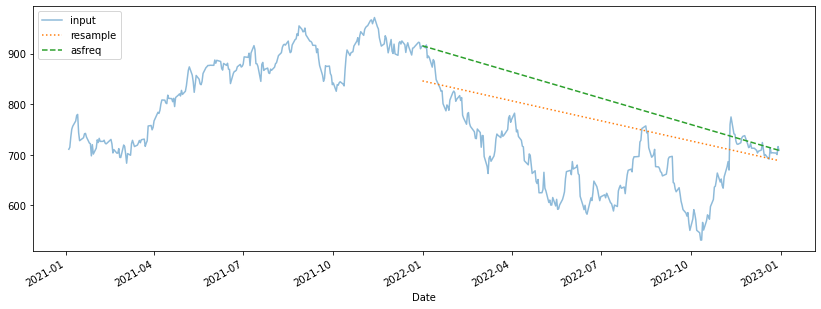

In [7]:
df_close = df['Close']
df_close.plot(figsize=(14, 5),alpha=0.5, style='-')
df_close.resample('BA').mean().plot(style=':')
df_close.asfreq('BA').plot(style='--');
plt.legend(['input', 'resample', 'asfreq'],
           loc='upper left');

<AxesSubplot:xlabel='Date'>

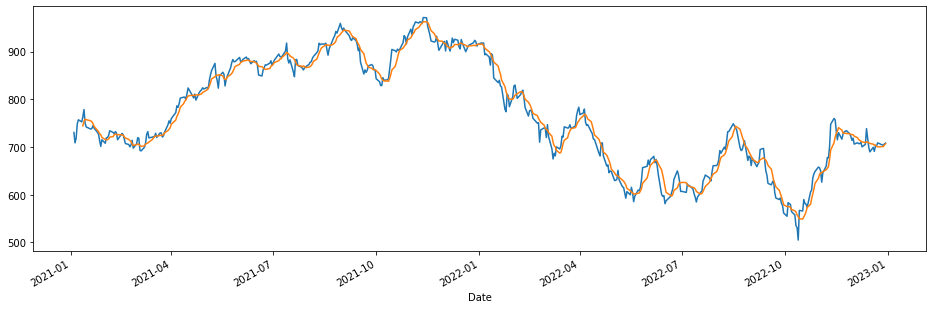

In [8]:
# Calculation the rolling 7-day Close price
df['Open'].plot()
df.rolling(7).mean()['Close'].plot(figsize=(16, 5))

<AxesSubplot:xlabel='Date'>

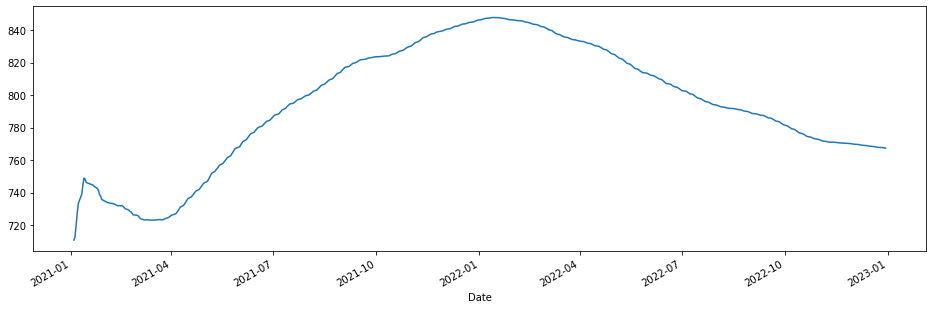

In [9]:
# Expanding average close price
df['Close'].expanding().mean().plot(figsize=(16, 5))

## Bollinger Bands
Bollinger Bands are a popular technical analysis tool used to determine the volatility of a financial instrument. 
They consist of a simple moving average (SMA) and two standard deviation lines (bands) plotted above and below the SMA.

<AxesSubplot:xlabel='Date'>

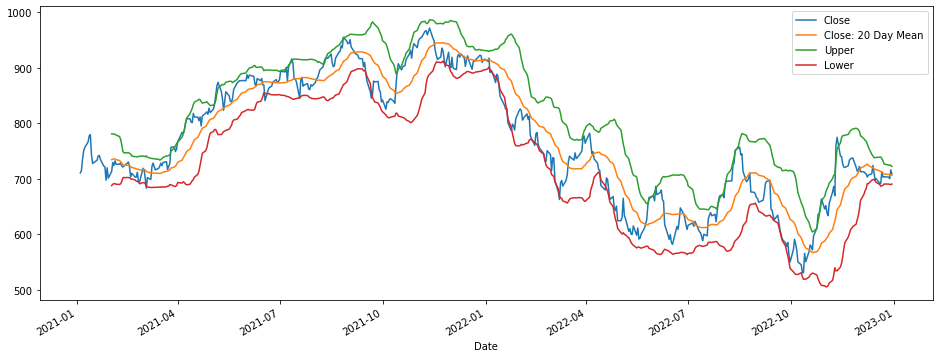

In [10]:
# Close 20 MA (M)
df['Close: 20 Day Mean'] = df['Close'].rolling(20).mean()

# Upper = 20MA + 2*std(20)
df['Upper'] = df['Close: 20 Day Mean'] + 2 * (df['Close'].rolling(20).std())

# Lower = 20MA - 2*std(20)
df['Lower'] = df['Close: 20 Day Mean'] - 2 * (df['Close'].rolling(20).std())

# Plot Close
df[['Close', 'Close: 20 Day Mean', 'Upper', 'Lower']].plot(figsize=(16, 6))

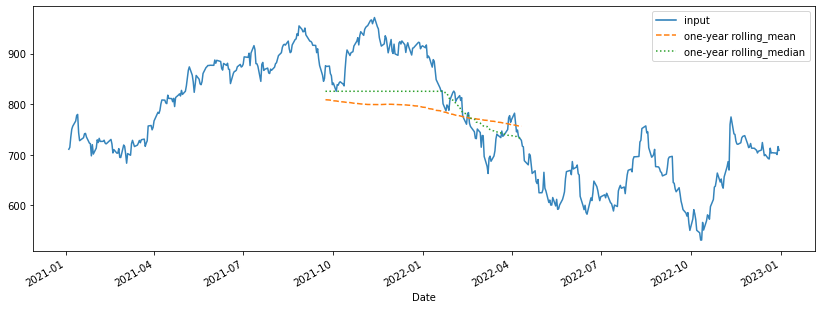

In [12]:
rolling = df_close.rolling(365, center=True)

data = pd.DataFrame({'input': df_close,
                     'one-year rolling_mean': rolling.mean(),
                     'one-year rolling_median': rolling.median()})
ax = data.plot(figsize=(14, 5),style=['-', '--', ':'])
ax.lines[0].set_alpha(0.9)

# Time Series Analysis
## ETS model (Error-Trend-Seasonality)

In [50]:
result = seasonal_decompose(df['Adj Close'], model='additive', period=12)

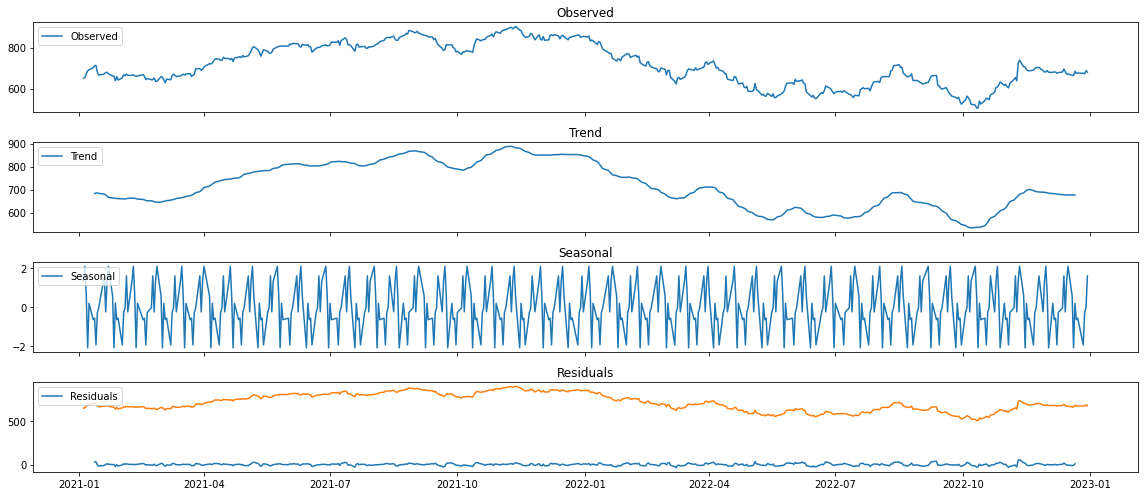

In [51]:
trend = result.trend
seasonal = result.seasonal
residuals = result.resid
observed = result.observed

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(16, 7), sharex=True)
ax1.plot(observed, label='Observed')
ax1.set_title('Observed')
ax1.legend(loc='upper left')

ax2.plot(trend, label='Trend')
ax2.set_title('Trend')
ax2.legend(loc='upper left')

ax3.plot(seasonal, label='Seasonal')
ax3.set_title('Seasonal')
ax3.legend(loc='upper left')

ax4.plot(residuals, label='Residuals')
ax4.set_title('Residuals')
ax4.legend(loc='upper left')
plt.tight_layout()
ax4.plot(observed)

## SME (Simple Moving Averages)


<AxesSubplot:xlabel='Date'>

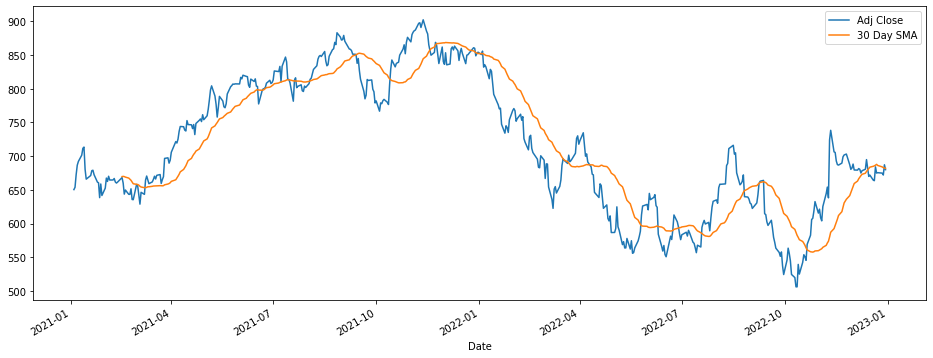

In [15]:
# creating SME (Simple Moving Averages)
df['30 Day SMA'] = df['Adj Close'].rolling(window=30).mean()
df[['Adj Close', '30 Day SMA']].plot(figsize=(16, 6))

## EWMA (Exponentially Weighted Moving Averages)
The moving average is designed as such that older observations are given lower weights. The weights fall exponentially as the data point gets older – hence the name exponentially weighted.

The only decision a user of the EWMA must make is the parameter alpha. The higher the value of alpha, the more closely the EWMA tracks the original time series.

<AxesSubplot:xlabel='Date'>

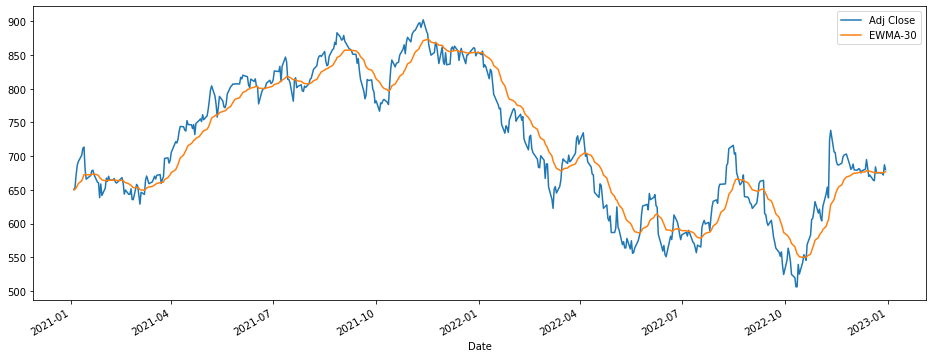

In [16]:
# creating EWMA (Exponentially Weighted Moving Averages)
df['EWMA-30'] = df['Adj Close'].ewm(span=20, adjust=False).mean()
df[['Adj Close', 'EWMA-30']].plot(figsize=(16, 6))

## Converting Frequencies
Since Stock Market data is only available for business days, the top panel contains gaps indicating NA values. The bottom panel compares two methods for filling these gaps: forward filling and backward filling.

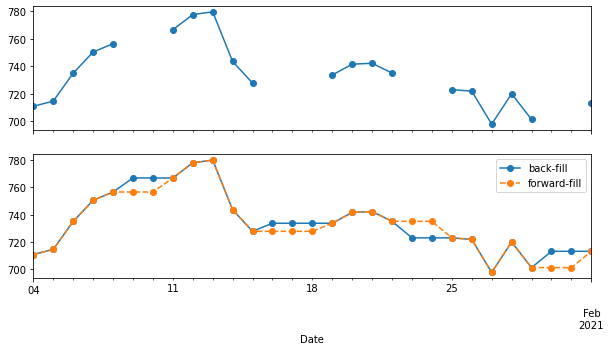

In [17]:
fig, ax = plt.subplots(2, sharex=True)
data = df_close.iloc[:20]

data.asfreq('D').plot(figsize=(10, 5),ax=ax[0], marker='o')

data.asfreq('D', method='bfill').plot(ax=ax[1], style='-o')
data.asfreq('D', method='ffill').plot(ax=ax[1], style='--o')
ax[1].legend(["back-fill", "forward-fill"]);

## Calculating ROI (Return on Investment)
ROI is calculated by dividing the net profit from the investment by the initial cost of the investment, and it is usually expressed as a percentage.

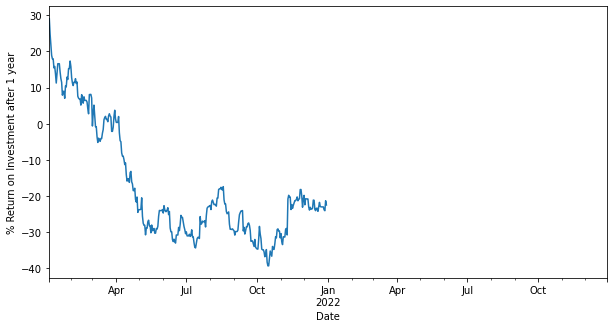

In [18]:
df_close = df_close.asfreq('D', method='pad')

ROI = 100 * (df_close.shift(-365) - df_close) / df_close
ROI.plot(figsize=(10, 5))
plt.ylabel('% Return on Investment after 1 year');

## Overview
This research demonstrates the ability to implement Time Series Analysis on stock market data.
Through the project indicators were calculated:
1. Datetime Indexing: Converting dates into Pandas datetime objects.
2. Resampling: Changing the frequency of time series data (e.g., daily to monthly).
3. Time Shifts: Shifting data in time to create lagged series.
4. Rolling Windows: Applying functions over moving time windows.
5. Handling Missing Data: Using forward and backward filling techniques.

# SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors)
Components:

Seasonal ARIMA (SARIMA): Extends ARIMA by including seasonal components:

Seasonal AutoRegressive (SAR) part: Accounts for autoregression at seasonal lags.
Seasonal Integrated (SI) part: Applies differencing at seasonal intervals to make the series stationary.
Seasonal Moving Average (SMA) part: Accounts for moving average at seasonal lags.
Seasonal Period (S): Defines the length of the seasonal cycle.

In [72]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_close.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.387996
p-value: 0.588017


Our time series is not stationary, but in the next sections we will do an automated parameter search for the ARIMA model and find the necessary parameters that will bring the series to stationarity.

## Ways to drive the series to stationarity

Differentiation: one of the most common methods, it is by differentiation that ARIMA brings the series to stationarity. This process is based on calculating the difference between successive observations in the time series. 

Seasonal differentiation: a variation of conventional differentiation that is applied to data with a seasonal component

Logarithmization: creating a logarithm of the data can help to reduce the variability of the series and make it more stationary. 

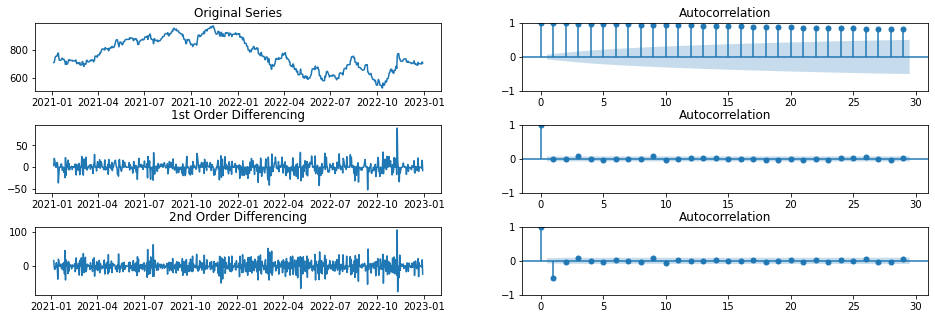

In [82]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(3, 2, sharex=False,figsize=(16, 5))
axes[0, 0].plot(df_close); axes[0, 0].set_title('Original Series')
plot_acf(df_close, ax=axes[0, 1])
# 1st Differencing
axes[1, 0].plot(df_close.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_close.diff().dropna(), ax=axes[1, 1])
# 2nd Differencing
axes[2, 0].plot(df_close.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df_close.diff().diff().dropna(), ax=axes[2, 1])
plt.subplots_adjust(hspace=0.5)
plt.show()

In this case the first order differentiation leads the time series to stationarity

## Construction and estimation of the SARIMAX model

In [60]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(df_close, order=(1, 1, 1), seasonal_order=(1, 1, 1, 15))
results = model.fit()
print(results.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.92996D+00    |proj g|=  5.71714D-02


 This problem is unconstrained.



At iterate    5    f=  3.86007D+00    |proj g|=  4.81822D-02

At iterate   10    f=  3.82248D+00    |proj g|=  1.98874D-04

At iterate   15    f=  3.82248D+00    |proj g|=  7.43242D-04

At iterate   20    f=  3.82244D+00    |proj g|=  1.17688D-03

At iterate   25    f=  3.82232D+00    |proj g|=  2.25999D-03

At iterate   30    f=  3.82210D+00    |proj g|=  9.73429D-03

At iterate   35    f=  3.82057D+00    |proj g|=  1.46374D-03

At iterate   40    f=  3.82038D+00    |proj g|=  6.14856D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     43     52      1     0     0   3.429D-05   3.820D+00
  F =   3.82037547253

## Sarimax model results overview

Information Criterion (AIC): a smaller AIC value indicates a better model fit.

Ljung-Box (L1) (Q): this is the p-value for the Ljung-Box Q-statistic. The value is greater than 0.05, the residuals are random, which is good.

Coefficients: they should be statistically significant. The p-values of the coefficients (P>|z|) are less than 0.05. 

Heteroskedasticity (H): this is a test for heteroskedasticity of the residuals. If Prob(H) (two-sided) is greater than 0.05, the residuals are heteroskedastic, which is good.

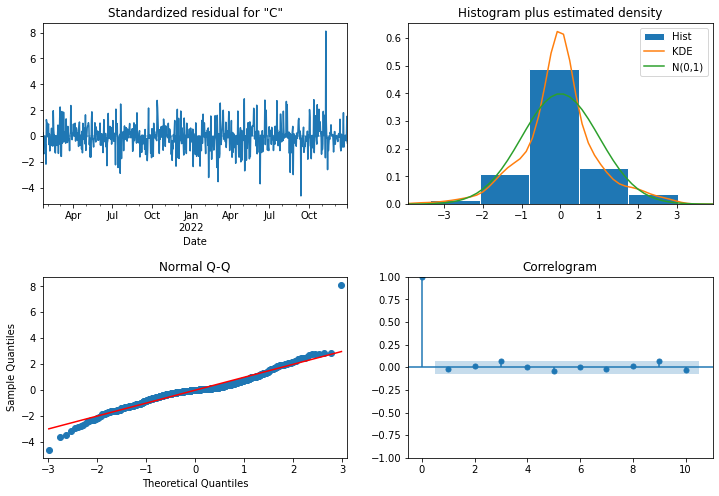

In [85]:
results.plot_diagnostics(figsize=(12, 8))
plt.subplots_adjust(hspace=0.4)
plt.show()

The residual curve is a graph of the model's residuals over time. The model is good, the residuals are random, and the plot looks like white noise. 

The normal quantile plot (Q-Q plot) is a graph that compares the distribution of residuals to a perfect normal distribution. The dots follow a diagonal line, this means that the residuals are normally distributed.

A correlogram plot is a plot of the autocorrelation of the residuals. The residuals are not correlated with each other. The absence of blue bars outside the blue noise range indicates this. 

The histogram of residuals is a histogram of the distribution of residuals. Residuals should be normally distributed, and this histogram resembles a bell shape. 

## Model parameters results
We have selected a model that generally meets the requirements, however, the potential to improve the parameters of the seasonal ARIMA model is still present. The application of SARIMA to time series often requires careful consideration and it is always useful to conduct a thorough data analysis and devote more time to data preprocessing and exploratory analysis before applying time series models. 

In [62]:
st_pred = results.get_prediction(start=pd.to_datetime('2022-03-02'), dynamic=False)
forecast_values = st_pred.predicted_mean

Now we have predicted values that we can compare to real time series data. We will use the mean square error (MSE) as our metric for assessing forecast accuracy: 

In [88]:
actual_values = df_close['2022-02-01':]
forecast_mse = ((forecast_values - actual_values) ** 2).mean()
print('The RMS error of the forecast is as follows {}'.format(round(forecast_mse, 2)))

The RMS error of the forecast is as follows 177.85


MSE is a common metric for assessing the quality of forecasting models. The lower the MSE value, the more accurate the model. Of course, there is no perfect model, and there will always be some deviation between forecasts and real data.

This code plots the real and predicted values of a stock over time. The red line represents the predicted values and the blue line represents the actual data. 

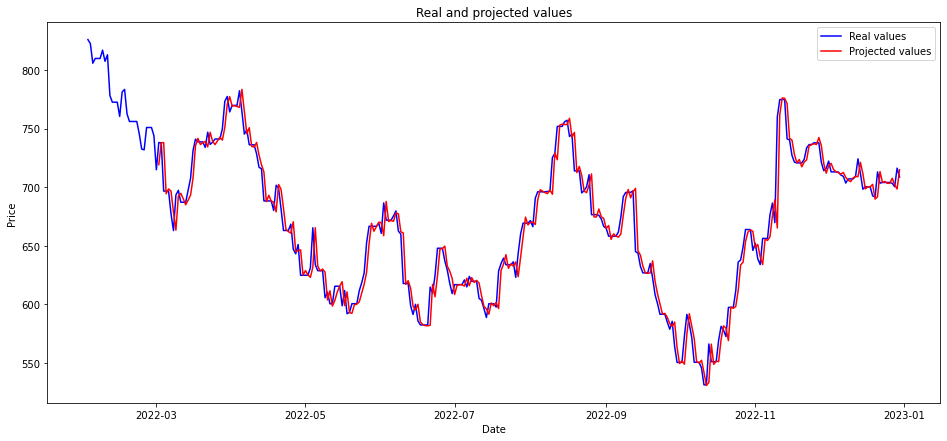

In [87]:
plt.figure(figsize=(16,7))

plt.plot(actual_values.index, actual_values, label='Real values', color='blue')

plt.plot(forecast_values.index, forecast_values, label='Projected values', color='red')

plt.title('Real and projected values')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

# Conclusion
The use of ARIMA helps our understanding in applying more sophisticated forecasting approaches. It is important to remember that the ARIMA model may not work for all series and the results will depend on the quality of your input data and pre-processing.